In [3]:
import torchvision
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataloader import DataLoader
from mydataset import MyDataset, acc
import copy

nways = 4

In [4]:
bsize = 8
ksize = 3
dataset = MyDataset(k=ksize+1, n=nways, ntrain=800, is_train=True)
dataset_test = MyDataset(k=ksize, n=nways, ntrain=800, is_train=False)

loader = torch.utils.data.DataLoader(dataset, batch_size=bsize, num_workers=3)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=bsize, num_workers=3)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
class Model(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.pixs = 27**2
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64,128, 3)
        self.pad   = nn.ZeroPad2d(1)

        self.pool = nn.MaxPool2d(2)
        self.lin1 = nn.Linear(512*4, 32)
        self.lin2 = nn.Linear(32, nways)

    def forward(self, x):
        x0 = x.shape
        x = x.view(-1, 1, x.shape[-2], x.shape[-1])
        h = self.conv1(x)
        h = self.pool(h)
        h = F.relu(h)

        h = self.conv2(h)
        h = self.pool(h)
        h = F.relu(h)

        h2 = self.pad(h)
        h2 = self.conv3(h2)
        h2 = F.relu(h2)
        h = h2

        h2 = self.pad(h)
        h2 = self.conv4(h2)
        h2 = F.relu(h2)
        h = h2

        h = h.view(h.shape[0], -1)
        h = self.lin1(h)
        h = F.relu(h)
        h = self.lin2(h)
        h = torch.softmax(h, dim=-1)
        return h.view(x0[0], x0[1], h.shape[-1])
model = Model()
        

In [14]:
opt_outer = torch.optim.Adam(model.parameters(), lr=2e-3)

In [15]:
def mymaml_grad(model, intrain, targtrain, intest, targtest, lr):
    params = list(model.parameters())
    return_grads = None
    batch_size = len(intrain)
    cumloss = 0
    cumacc = 0

    for x_train, y_train, x_test, y_test in zip(intrain, targtrain, intest, targtest):

        model1 = copy.deepcopy(model)
        preds = model1(x_train)
        loss1 = -(y_train*torch.log(preds+1e-8)).mean()
        loss1.backward(create_graph=True, retain_graph=True)

        model2 = copy.deepcopy(model)
        news = []
        for param1, param2 in zip(model1.parameters(), model2.parameters()):
            tmp = param1 - lr*param1.grad 
            param2.data.copy_(tmp)
            news.append(tmp)

        preds = model2(x_test)
        loss = -(y_test*torch.log(preds+1e-8)).mean()/batch_size
        cumacc += acc(y_test, preds)
        cumloss += loss.item()
        grads1 = torch.autograd.grad(loss, list(model2.parameters()))
        grads2 = torch.autograd.grad(news, list(model1.parameters()), grad_outputs=grads1)

        if return_grads is None:
            return_grads = list(grads2)
        else:
            for i, g2 in enumerate(grads2):
                return_grads[i] += g2
    for p, g in zip(model.parameters(), return_grads):
        with torch.no_grad():
            if p.grad is None:
                p.grad = g
                continue
            p.grad += g
    return cumloss, cumacc/batch_size

In [16]:
eps=1000
ii = 0
writer = SummaryWriter('tb/maml_test_novi_k=2_nways=5_again__')
for ep in range(eps):
    for step, (x, y) in enumerate(loader):
        xexamples, xtoguess = x[:, :-1], x[:, -1].unsqueeze(1)
        yexamples, ytoguess = y[:, :-1], y[:, -1].unsqueeze(1)
        opt_outer.zero_grad()
        loss, accuraccy = mymaml_grad(model, xexamples, yexamples, xtoguess, ytoguess, 0.05)
        opt_outer.step()
        writer.add_scalar('metric/loss', loss, ii := ii+1)
        writer.add_scalar('metric/accu', accuraccy, ii)
        import time 
        time.sleep(5) 
    print(ep, step, loss, accuraccy)

KeyboardInterrupt: 

In [175]:
for x, y in loader:
    break
xexamples, xtoguess = x[0, :-1].unsqueeze(0), x[0, -1].unsqueeze(0).unsqueeze(1)
yexamples, ytoguess = y[0, :-1].unsqueeze(0), y[0, -1].unsqueeze(0).unsqueeze(1)
reptile_optimize(model, xexamples, yexamples, xtoguess, ytoguess, 1e-2, 10, 0.9, update_model=False)

torch.Size([1, 3, 4, 27, 27]) torch.Size([1, 3, 4, 4]) torch.Size([1, 1, 4, 27, 27]) torch.Size([1, 1, 4, 4])


(0.3265857398509979,
 0.5,
 tensor([[[0.7942, 0.1295, 0.0135, 0.0628],
          [0.5859, 0.3632, 0.0149, 0.0359],
          [0.4564, 0.0404, 0.1731, 0.3300],
          [0.0151, 0.0053, 0.0198, 0.9597]]], grad_fn=<ViewBackward>))

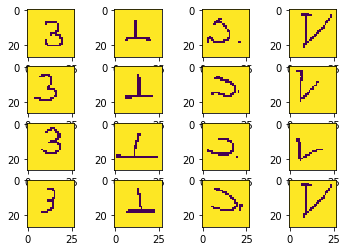

In [176]:
br = 0
for i, kx in enumerate(torch.cat((xexamples[0], xtoguess[0]), dim=0)):
    for j, x in enumerate(kx):
        plt.subplot(4, nways, br := br+1)
        plt.imshow(x.numpy())